In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance, distance_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, LeaveOneOut
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
import matplotlib.pyplot as plt
from collections import Counter
from copy import deepcopy
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from threading import Thread
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Creation usefull instruments

In [2]:
class Color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

    
# function allows to print colorful and bold text
def pretty_print(text="", text_headers="", color="", bold=False):
    bold_part = Color.BOLD if bold else ""
    color_part = Color.__dict__.get(color.upper(), "")
    print(bold_part + color_part + text_headers + Color.END + text)


In [3]:
class Result:
    
    def __init__(self, model_name, model_parameters, model_score, data_for_graphics):
        self.__name = model_name
        self.__parameters = model_parameters
        self.__score = model_score
        if len(data_for_graphics) == 3:
            self.__X_test = data_for_graphics[0]
            self.__y_test = data_for_graphics[1]
            self.__y_hat = data_for_graphics[2]
        else:
            print("Model %s has no data for graphics", model_name)
            self.__X_test = None
            self.__y_test = None
            self.__y_hat = None
        
    def get_name(self):
        return self.__name
    
    def get_parameters(self):
        return self.__parameters
    
    def get_score(self):
        return self.__score

    def show_result_graphics(self):
        X_test = self.__X_test
        y_test = self.__y_test
        y_hat = self.__y_hat
        if  X_test is not None and y_test is not None and y_hat is not None:
            plt.subplot(1, 2, 1)
            plt.title("y_hat")
            plt.scatter(np.linspace(0, len(y_hat), len(y_hat)), y_hat, c='orange')
            plt.subplot(1, 2, 2)
            plt.title("y_test")
            plt.scatter(np.linspace(0, len(y_test), len(y_test)), y_test)
    
    def classification_report(self):
        print(self.__name)
        print(classification_report(self.__y_hat, self.__y_test))
    
class Results:
    
    def __init__(self):
        self.__results = {}
        
    def create_id(self):
        new_key = 0
        keys = self.__results.keys()
        if keys:
            new_key = max(self.__results.keys()) + 1
        return new_key
    
    def add_result(self, model_name, model_parameters, model_score, data_for_graphics):
        self.__results.update({model_name: Result(model_name, model_parameters, model_score, data_for_graphics)})
        
    def get_scores(self, show_model_parameters=False):
        results = {}
        result_dataframe_index = self.__results.keys()
        result_dataframe_columns = ["accuracy", "precision", "recall", "f_score"]
        result_df = pd.DataFrame(index=result_dataframe_index, columns=result_dataframe_columns)

        for key, result_object in self.__results.items():
            model_scores = result_object.get_score()
            result_df.loc[key]["accuracy"] = model_scores.get("accuracy")
            result_df.loc[key]["precision"] = model_scores.get("precision")
            result_df.loc[key]["recall"] = model_scores.get("recall")
            result_df.loc[key]["f_score"] = model_scores.get("f_score")
            result_df.loc[key]["parameters"] = result_object.get_parameters()
 
        return result_df
    
    def get_results(self):
        return self.__results
    
    def get_concrete_result(self, model_name):
        return self.__results.get(model_name)

## Data loading from scv files
1. all_data - data of morning and afternoon datasets
2. morning_data - data of morning dataset
3. afternoon_data - data of afternoon dataset

In [4]:
separator = ','
all_data = pd.read_csv("all_data_preprocessed_filtering.csv", sep=separator)
morning_data = pd.read_csv("morning_data.csv", sep=separator)
afternoon_data =pd.read_csv("afternoon_data.csv", sep=separator)
datasets = [all_data, morning_data, afternoon_data]

In [5]:
all_data.head()

,age,gender,weight,smoking,diseasehypertonia,respiratory_disease,p_a,p_da,t_right_slopes,interval_pq,kurtosis,nn50,lfp,br
0,65,1,81,1,0,0,0.008323,0.000011,-0.000266,-0.149,1.183951,0,0.416088,31.292105
1,43,0,60,0,0,0,0.007437,0.000032,-0.000282,-0.054,0.573783,0,0.123064,36.408043
2,73,0,92,0,1,0,0.009876,0.000015,-0.000392,-0.091,0.321415,0,0.119404,19.919365
3,61,1,55,1,0,1,0.007188,0.000004,-0.000426,-0.079,0.205573,0,0.326354,20.744604
4,63,1,65,1,1,1,0.007358,-0.000011,-0.000370,-0.069,-0.389226,0,0.222550,17.599829


## Function for process

In [6]:
# function for creation data for model fitting process
def create_models_data(df, models_data, test_size=0.3):
    models = []
    for model_data in models_data:
        dataframe_info = [df, test_size]
        dataframe_info.extend(model_data)
        models.append(dataframe_info)
    return models

# classification report in dict view
def classification_scores(y_hat, y_test):
    scores = {}
    scores["accuracy"] = accuracy_score(y_hat, y_test)
    scores["precision"] = precision_score(y_hat, y_test)
    scores["recall"] = recall_score(y_hat, y_test)
    scores["f_score"] = f1_score(y_hat, y_test)
    return scores

In [9]:
class ModelsCollector:
    def __init__(self):
        self.results = None
        
    def set_collector_object(self, collector_object):
        self.results = collector_object

    def basic_model(self, df, test_size, model_object, model_saving_name):
        def model_function(df, test_size, model_object, model_saving_name):
            data = deepcopy(df)
            y = data['respiratory_disease']
            X = data.drop(['respiratory_disease'], axis=1)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)  
            model_object.fit(X_train, y_train)
            y_hat = model_object.predict(X_test)
            model_score = classification_scores(y_hat, y_test)
            data_for_graphics = [X_test, y_test, y_hat]
            self.results.add_result(model_saving_name, model_object.get_params(), model_score, data_for_graphics)

        model_thread = Thread(target=model_function, args=[df, test_size, model_object, model_saving_name])
        model_thread.start()

    def GSCV_model(self, df, test_size, model_object, model_saving_name, parameters):
        def model_function(df, test_size, model_object, model_saving_name, parameters):
            data = deepcopy(df)
            y = data['respiratory_disease']
            X = data.drop(['respiratory_disease'], axis=1)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)  
            classifier = GridSearchCV(model_object, parameters)
            classifier.best_estimator_.fit(X_train, y_train)
            model_score = classification_scores(y_hat, y_test)
            self.results.add_result(model_saving_name, model_object.get_params(), model_score, data_for_graphics)

        model_thread = Thread(target=model_function, args=[df, test_size, model_object, model_saving_name, parameters])
        model_thread.start()
        
    def KFOLD_model(self, df, test_size, model_object, model_saving_name, n_splits, shuffle=False, random_state=None):
        def model_function(df, test_size, model_object, model_saving_name, n_splits, shuffle=False, random_state=None):
            results = []
            kf = KFold(n_splits=2, shuffle=shuffle, random_state=random_state)
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                model_object.fit(X_train, y_train)
                y_hat = model_object.predict(X_test)
                model_score = classification_scores(y_hat, y_test)
                data_for_graphics = [X_test, y_test, y_hat]
                self.results.add_result(model_saving_name, model_object.get_params(), model_score, data_for_graphics)

        model_thread = Thread(target=model_function, args=[df, test_size, model_object, model_saving_name])
        model_thread.start()

## Models

In [10]:
LGR_basic = [LogisticRegression(), "LogisticRegression_basic"]
DTC_basic = [DecisionTreeClassifier(), "DecisionTreeClassifier_basic"]
SVC_basic = [SVC(), "SVC_basic"]
KNC_basic = [KNeighborsClassifier(), "KNeighborsClassifier_basic"]
RFC_basic = [RandomForestClassifier(), "RandomForestClassifier_basic"]
LSVC_basic = [LinearSVC(), "LinearSVC_basic"]
models_data = [LGR_basic, DTC_basic, SVC_basic, KNC_basic, RFC_basic, LSVC_basic]
models = create_models_data(all_data, models_data=models_data, test_size=0.3)
models_collector = ModelsCollector()
results = Results()  # object for saving results
models_collector.set_collector_object(results)

In [12]:
for model in models:
    models_collector.basic_model(*model)

In [13]:
results.get_scores()

,accuracy,precision,recall,f_score
KNeighborsClassifier_basic,0.933121,0.996534,0.934959,0.964765
DecisionTreeClassifier_basic,0.890127,0.931624,0.949477,0.940466
LogisticRegression_basic,0.926752,1,0.926752,0.961983
RandomForestClassifier_basic,0.952229,0.991525,0.959016,0.975
LinearSVC_basic,0.904459,1,0.904459,0.949833
SVC_basic,0.923567,1,0.92283,0.959866


### Results review
Thought we have really great perfomance, our models are not good, because number of objects for fitting was imbalanced, 
number of patients of class 0 was too low

### DecisionTreeClassifier_basic

Total score of model is: {'accuracy': 0.8837579617834395, 'precision': 0.9360967184801382, 'recall': 0.9377162629757786, 'f_score': 0.9369057908383752}


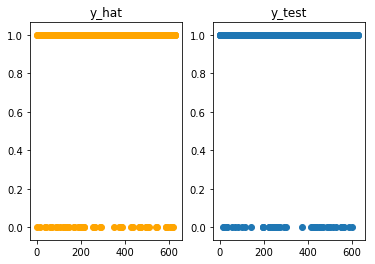

In [67]:
result_object = results.get_concrete_result('DecisionTreeClassifier_basic')
result_object.show_result_graphics()
print("Total score of model is:", result_object.get_score())

### KNeighborsClassifier_basic

Total score of model is: {'accuracy': 0.9490445859872612, 'precision': 0.9983079526226735, 'recall': 0.9500805152979066, 'f_score': 0.9735973597359736}


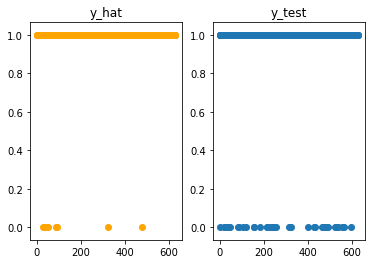

In [68]:
result_object = results.get_concrete_result('KNeighborsClassifier_basic')
result_object.show_result_graphics()
print("Total score of model is:", result_object.get_score())

### LinearSVC_basic

Total score of model is: {'accuracy': 0.9171974522292994, 'precision': 1.0, 'recall': 0.9171974522292994, 'f_score': 0.9568106312292359}


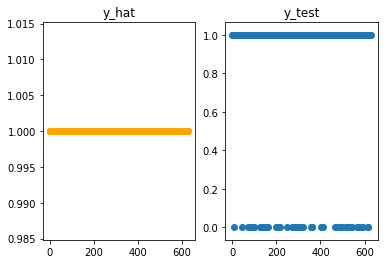

In [69]:
result_object = results.get_concrete_result('LinearSVC_basic')
result_object.show_result_graphics()
print("Total score of model is:", result_object.get_score())

### LogisticRegression_basic

Total score of model is: {'accuracy': 0.9347133757961783, 'precision': 0.9982935153583617, 'recall': 0.936, 'f_score': 0.9661436829066887}


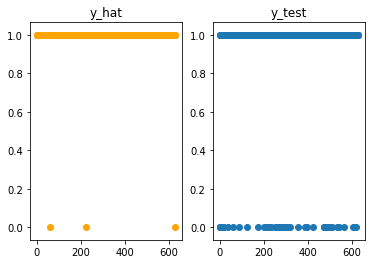

In [70]:
result_object = results.get_concrete_result('LogisticRegression_basic')
result_object.show_result_graphics()
print("Total score of model is:", result_object.get_score())

### RandomForestClassifier_basic

Total score of model is: {'accuracy': 0.9235668789808917, 'precision': 0.9965034965034965, 'recall': 0.9253246753246753, 'f_score': 0.9595959595959596}


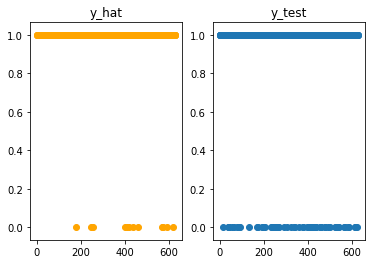

In [71]:
result_object = results.get_concrete_result('RandomForestClassifier_basic')
result_object.show_result_graphics()
print("Total score of model is:", result_object.get_score())

### SVC_basic

Total score of model is: {'accuracy': 0.9315286624203821, 'precision': 0.9982758620689656, 'recall': 0.9323671497584541, 'f_score': 0.9641965029142381}


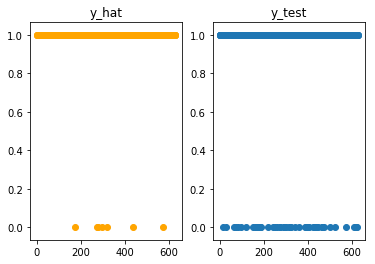

In [72]:
result_object = results.get_concrete_result('SVC_basic')
result_object.show_result_graphics()
print("Total score of model is:", result_object.get_score())

### Logistic Regression GSCV

## Class balancing

### Oversampling

In [14]:
df = deepcopy(all_data)

In [15]:
df_major = df[df.respiratory_disease == 1]
df_minor = df[df.respiratory_disease == 0]
df_minor_upsampled = resample(df_minor, replace=True, n_samples=df_major.shape[0])
df_oversampled = pd.concat([df_major, df_minor_upsampled])

### Undersampling

In [16]:
df_major = df[df.respiratory_disease == 1]
df_minor = df[df.respiratory_disease == 0]
df_major_downsampled = resample(df_major, replace=True, n_samples=df_minor.shape[0])
df_undersampled = pd.concat([df_minor, df_major_downsampled])

### Models fitting

In [18]:
models_data = [LGR_basic, DTC_basic, SVC_basic, KNC_basic, RFC_basic, LSVC_basic]
models = create_models_data(df_oversampled, models_data=models_data, test_size=0.3)
results_oversampled_data = Results()  # object for saving results
models_collector.set_collector_object(results_oversampled_data)

In [20]:
for model in models:
    models_collector.basic_model(*model)

In [22]:
results_oversampled_data.get_scores()

,accuracy,precision,recall,f_score
LogisticRegression_basic,0.618307,0.603093,0.624555,0.613636
DecisionTreeClassifier_basic,0.96114,0.923208,1,0.960071
KNeighborsClassifier_basic,0.949914,0.916667,0.983577,0.948944
RandomForestClassifier_basic,0.992228,0.984266,1,0.99207
LinearSVC_basic,0.508636,0.994792,0.503073,0.668222
SVC_basic,0.991364,0.982425,1,0.991135


In [23]:
models_data = [LGR_basic, DTC_basic, SVC_basic, KNC_basic, RFC_basic, LSVC_basic]
models = create_models_data(df_undersampled, models_data=models_data, test_size=0.3)
results_undersampled_data = Results()  # object for saving results
models_collector.set_collector_object(results_undersampled_data)

In [24]:
for model in models:
    models_collector.basic_model(*model)

In [25]:
results_undersampled_data.get_scores()

,accuracy,precision,recall,f_score
LogisticRegression_basic,0.55102,0.541667,0.541667,0.541667
KNeighborsClassifier_basic,0.642857,0.630435,0.617021,0.623656
SVC_basic,0.55102,0.314815,0.708333,0.435897
DecisionTreeClassifier_basic,0.683673,0.66,0.702128,0.680412
LinearSVC_basic,0.561224,1,0.556701,0.715232
RandomForestClassifier_basic,0.642857,0.625,0.714286,0.666667


In [ ]:

data = deepcopy(all_data)
y = data['respiratory_disease']
X = data.drop(['respiratory_disease'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)  # sharing dataset on train and test


parameters = {'kernel':('rbf', 'sigmoid'), 'C':[1, 10]}
classifier = GridSearchCV(SVC(), parameters)
classifier.fit(X_train, y_train)